# Natural Language Processing

Toxicity Demo - try it on your own, I warned you!

https://storage.googleapis.com/tfjs-models/demos/toxicity/index.html

Source code:

https://github.com/tensorflow/tfjs-models/tree/master/toxicity

## Visualize word embeddings

In [31]:
# we need to convert words/parts of words into numerical representations used by neural network for training

# cf dimensionality reduction with convolution and pooling - e.g. reducing imgs of handwritten digits to 11 degrees of freedom
# while preserving most important information - can do sth similar w/ words

# specify n degrees of freedom
# each word will be a point in this multidimensional space
# idea is for the neural network to figure out where to place words with similar meaning (synonyms will be close to each other),
# but also figure out relationshipts between words (e.g. that boy->man has similar relationship to girl->woman: distance (and directionality???)
# between these pairs will be similar) 

# this technique is called embedding:
# assigning coordinates to words in multidimensional space by analyzing text

# keras has `layers.Embedding` method




In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# first run pip install tensorflow_datasets

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [33]:
layers.Embedding?
embedding_layer = layers.Embedding(1000, 5) 
# args to layers.Embedding:
# input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
# output_dim: Integer. Dimension of the dense embedding.

Init signature:
layers.Embedding(
    input_dim,
    output_dim,
    embeddings_initializer='uniform',
    embeddings_regularizer=None,
    embeddings_constraint=None,
    mask_zero=False,
    weights=None,
    lora_rank=None,
    **kwargs,
)
Docstring:     
Turns positive integers (indexes) into dense vectors of fixed size.

e.g. `[[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]`

This layer can only be used on positive integer inputs of a fixed range.

Example:

>>> model = keras.Sequential()
>>> model.add(keras.layers.Embedding(1000, 64))
>>> # The model will take as input an integer matrix of size (batch,
>>> # input_length), and the largest integer (i.e. word index) in the input
>>> # should be no larger than 999 (vocabulary size).
>>> # Now model.output_shape is (None, 10, 64), where `None` is the batch
>>> # dimension.
>>> input_array = np.random.randint(1000, size=(32, 10))
>>> model.compile('rmsprop', 'mse')
>>> output_array = model.predict(input_array)
>>> print(output_array.shape)


In [34]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[ 0.04673275, -0.00528001, -0.01936337,  0.01032853,  0.04899606],
       [ 0.02455292,  0.03961318,  0.03986819, -0.04009924,  0.02124909],
       [-0.03637197, -0.00498281,  0.00967758, -0.04020824, -0.02205483]],
      dtype=float32)

In [35]:
result = embedding_layer(tf.constant([[0,1,2,3],[3,4,5,6]]))
result.shape

TensorShape([2, 4, 5])

In [36]:
%%time
(train_data, test_data), info = tfds.load('imdb_reviews/subwords8k',
                                          split=(tfds.Split.TRAIN,
                                                 tfds.Split.TEST),
                                          with_info=True,
                                          as_supervised=True)

CPU times: user 146 ms, sys: 7.12 ms, total: 153 ms
Wall time: 50.8 ms


In [37]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

# elements ending with '_' are full words, the rest are pts of words

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [38]:
padded_shapes = ([None],())
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes = padded_shapes)
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes = padded_shapes)

In [39]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

2024-08-24 22:32:12.059776: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


array([[  12,  304,   15, ...,    0,    0,    0],
       [ 768,  284,    1, ...,    0,    0,    0],
       [  19, 4881,  643, ...,    0,    0,    0],
       ...,
       [ 147, 5293, 7986, ...,    0,    0,    0],
       [  12,  456,   45, ...,    0,    0,    0],
       [ 608, 7968,    8, ...,    0,    0,    0]])

In [40]:
embedding_dim = 16

model = keras.Sequential([
    layers.Embedding(encoder.vocab_size, embedding_dim), # 1st layer transforms vocab into 16-dimentional representation
    layers.GlobalAveragePooling1D(), # find avg for all those channels
    layers.Dense(1, activation='sigmoid') # positive or negative review
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [41]:
%%time 
# 1 minutes - just run it
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches,
                    validation_steps=20)

Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5580 - loss: 0.6838 - val_accuracy: 0.6100 - val_loss: 0.6153
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7102 - loss: 0.5664 - val_accuracy: 0.7400 - val_loss: 0.5046
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8035 - loss: 0.4454 - val_accuracy: 0.8500 - val_loss: 0.3555
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8349 - loss: 0.3798 - val_accuracy: 0.7950 - val_loss: 0.4389
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8486 - loss: 0.3475 - val_accuracy: 0.8200 - val_loss: 0.3668
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8686 - loss: 0.3206 - val_accuracy: 0.8250 - val_loss: 0.4146
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8826 - loss: 0.2889 - val_accuracy: 0.8000 - val_loss: 0.4233
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8882 - loss: 0.2776 - 

2024-08-24 22:32:48.187153: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


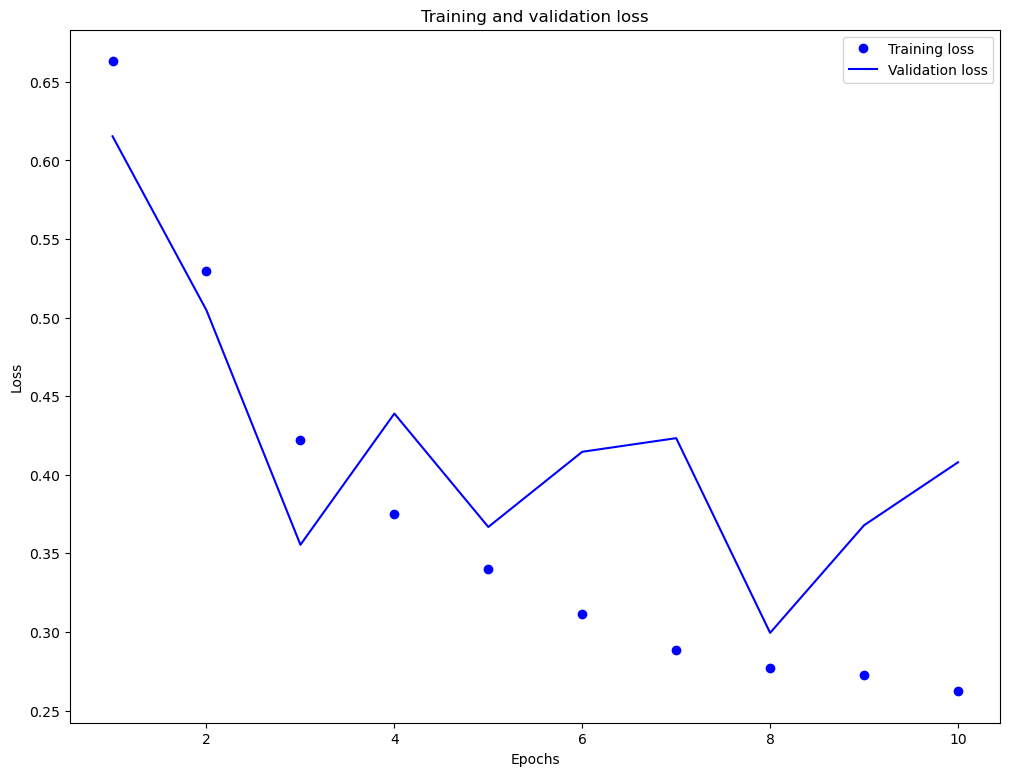

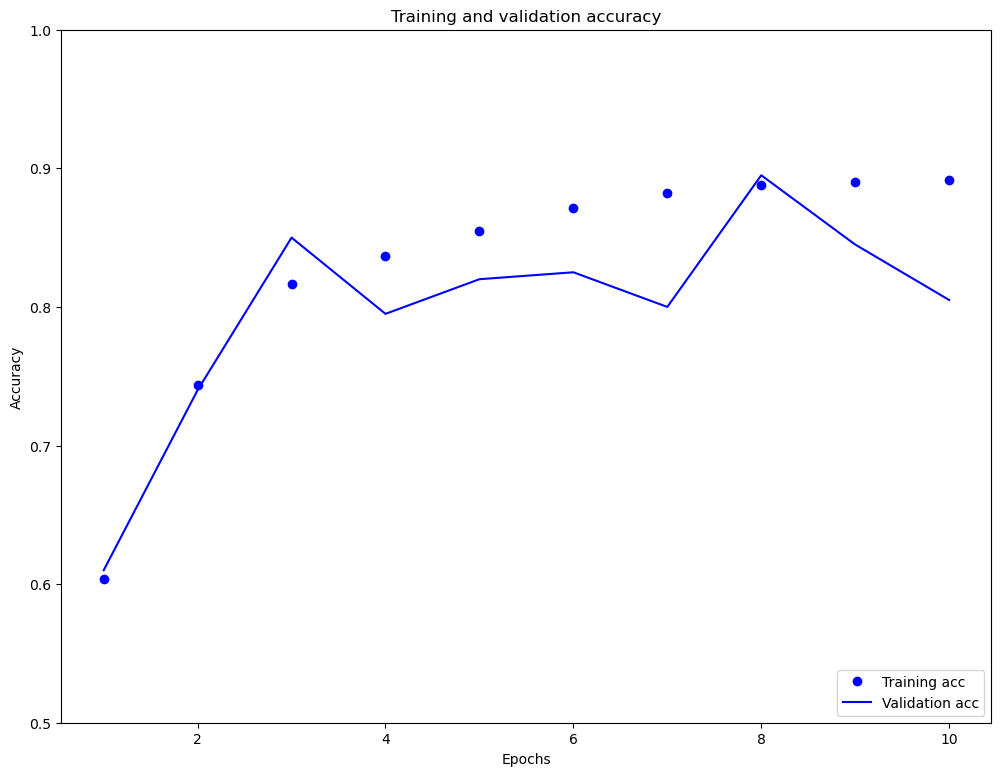

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [ ]:
# the loss and accuracy plots again show overfitting - acc grows until the 3rd epoch, then starts fluctuating 
# to avoid instability, can stop after third/forth epoch

In [43]:
e = model.layers[0] # embedding layer at idx 0
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


In [44]:
encoder = info.features['text'].encoder

In [45]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8') # save 16-dimensional vectors into file
out_m = io.open('meta.tsv', 'w', encoding='utf-8') # save words

# can visualize saved data using Embedding Projector (link below)

for num, word in enumerate(encoder.subwords):
    vec = weights[num + 1]  # skip 0, it's padding.
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

Open the [Embedding Projector](http://projector.tensorflow.org/)

http://projector.tensorflow.org/